In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

base: str = "./datasets/"

# Load Transactions dataset

In [2]:
transactions = pd.read_csv(
    base + "transactions.csv",
    names=['timestamp', 'blockId', 'txId', 'isCoinbase', 'fee'],
    dtype={'timestamp': np.uint32, 'blockId': np.uint32, 'txId': np.uint32, 'isCoinbase': np.uint8},
    parse_dates=True
)

#transactions[["timestamp", "blockId", "txId", "isCoinbase", "fee"]] = transactions[["timestamp", "blockId", "txId", "isCoinbase", "fee"]].apply(pd.to_numeric, downcast="unsigned")


#print(transactions.info())
#print(pd.concat([transactions.head(), transactions.tail()]))
#print(transactions.head())
#print(transactions.tail())

'''
max vals
timestamp: 1356997957 -> int64
blockId: 214562 -> int32
txId: 10572826 -> int32
isCoinbase -> np.bool_
fee: 17179869184 -> int64
'''

'''print(transactions.info())
print(transactions.memory_usage(deep=True))
print(transactions.nlargest(5, 'txId'))
'''
'''
Index              128           128
timestamp     84582632      42291316
blockId       42291316      42291316
txId          42291316      42291316
isCoinbase    84582632      10572829
fee           84582632      84582632
'''

'\nIndex              128           128\ntimestamp     84582632      42291316\nblockId       42291316      42291316\ntxId          42291316      42291316\nisCoinbase    84582632      10572829\nfee           84582632      84582632\n'

# Load Inputs dataset

In [3]:
inputs = pd.read_csv(
    base + "inputs.csv",
    names=['txId', 'prevTxId', 'prevTxPos'],
    dtype={'txId': np.uint32, 'prevTxId': np.uint32, 'prevTxPos': np.uint16},
)

# Load Outputs dataset 

In [4]:
outputs = pd.read_csv(
    base + "outputs.csv",
    names=['txId', 'txPos', 'addressId', 'amount', 'scriptType'],
    dtype={'txId': np.uint32, 'txPos': np.uint16, 'addressId': np.uint32, 'amount': np.uint64, 'scriptType': np.uint8}
)

print(outputs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24613799 entries, 0 to 24613798
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   txId        uint32
 1   txPos       uint16
 2   addressId   uint32
 3   amount      uint64
 4   scriptType  uint8 
dtypes: uint16(1), uint32(2), uint64(1), uint8(1)
memory usage: 446.0 MB
None


# Load Mappings dataset

In [5]:
mappings = pd.read_csv(
    base + "mappings.csv",
    names=['addressId', 'hash'],
    dtype={'addressId': str, 'hash': np.int32}
)

# Script table

In [ ]:
data = {'scriptCode': [0,1,2,3,4,5,6,7], 
        'scriptType':["Unknown", "P2PK", "P2KH", "P2SH", "RETURN", "EMPTY", "P2WPKH", "P2WSH"],
        'scriptSize': [0, 153, 180, 291, 0, 0, 0, 0]
       }

scripts = pd.DataFrame(
    data,
    #dtypes={'scriptCode': np.int8, 'scriptType': str, 'scriptSize': np.int8}
                  
)
print(scripts.info())
print(scripts)


# Number of transactions

In [ ]:
#Df to have the num of transactions for every timestamp
transCount = transactions \
    .groupby('timestamp')['txId'].count() \
    .reset_index() \
    .rename(columns={'txId':'txCount'})
print(transCount)

transCount.plot.line(title='Numero di transazioni nel tempo', x='timestamp', y='txCount')

# Utils

In [ ]:
def getTransactionInputs(inputsDf: pd.DataFrame, txId: int) -> pd.DataFrame:
    ''' Get all inputs of a transaction 
    
    Returns:
    DF<txId, prevTxId, prevTxPos>'''

    cond = inputsDf['txId'] == txId
    return inputsDf[cond]

def getTransactionOutputs(outputsDf: pd.DataFrame, txId: int) -> pd.DataFrame:
    ''' Get all outputs of a transaction 
    
    Returns:
    DF<txId, txPos, addressId, amount, scriptType>'''
    
    cond = outputsDf['txId'] == txId
    return outputsDf[cond]

def getTransactionSize(inputsDf: pd.DataFrame, outputsDf: pd.DataFrame, txId: int) -> float:
    ''' Ottieni la dimensione di una transazione '''
    
    INPUT_SIZE = 40
    OUTPUT_SIZE = 9

    num_inputs = len(getTransactionInputs(inputsDf, txId))
    num_outputs = len(getTransactionOutputs(outputsDf, txId))
    script_size = 0

    # TODO: num_outputs > 1 ==> script diversi; quale contare?
    return INPUT_SIZE * num_inputs + OUTPUT_SIZE * num_outputs + script_size

def getTransactionsAtTimestamp(transactionsDf: pd.DataFrame, timestamp: int) -> pd.DataFrame:
    """ Get all transaction at a given timestamp 
    
    Returns:
    DF<timestamp, blockId, txId, isCoinbase, fee>"""

    cond = transactionsDf['timestamp'] == timestamp
    return transactionsDf[cond]


def getCongestionAtTs(timestamp: int, transactionsDf: pd.DataFrame, inputsDf: pd.DataFrame, outputsDf: pd.DataFrame) -> int:
    """ Get the congestion at a given timestamp """
    
    transactions_at_ts = getTransactionsAtTimestamp(transactionsDf, timestamp).drop(columns=["blockId", "isCoinbase", "fee"])
    # transactions_at_ts: <timestamp, txId>

    tx_sizes: list[float] = [getTransactionSize(inputsDf, outputsDf, txId) for txId in transactions_at_ts['txId']]
    return sum(tx_sizes)


def getAverageFeeAtTimestamp(timestamp: int, transactionsDf: pd.DataFrame) -> float:
    tx_ts: pd.DataFrame = getTransactionsAtTimestamp(transactionsDf, timestamp)

    return tx_ts['fee'].mean()


def getTsCongestionDf(transactionsDf: pd.DataFrame, inputsDf: pd.DataFrame, outputsDf: pd.DataFrame) -> pd.DataFrame:
    ''' STEPS:
    Filter transactionsDf (remove coinbases)
    Get timestamps
    Get congestion at timestamp
    Get fee at timestamp
    '''
    
    not_coinbase = transactionsDf['isCoinbase'] == 0
    transactionsDf = transactionsDf[not_coinbase]

    n = 572828
    
    timestamps = transactionsDf['timestamp'][n:n+500]
    congs = timestamps.apply(getCongestionAtTs, args=(transactionsDf, inputsDf, outputsDf))
    fees = timestamps.apply(getAverageFeeAtTimestamp, args=(transactionsDf))
    
    return pd.DataFrame({'Timestamp': timestamps, 'Congestion': congs, 'Fee': fees})

In [ ]:
# test getTransactionInputs, getTransactionOutputs
TX_ID = 10888

txInputs = getTransactionInputs(inputs, TX_ID)
print(f'#tx_inputs: {len(txInputs)}')
print(txInputs)

txOutputs = getTransactionOutputs(outputs, TX_ID)
print(f'#tx_outputs: {len(txOutputs)}')
print(txOutputs)

In [ ]:
#get all transactions with more then 1 output
'''
for id in transactions['txId']:
    n_outputs = len(getTransactionOutputs(outputs, id))

    if n_outputs != 1:
        print(f'txId:{id:}, num_outputs: {n_outputs}')

print("end")'''

In [ ]:
# test getTransactionsAtTimestamp
timestamp = 1356997591
transactions_ncb = transactions[transactions['isCoinbase'] == 0]

tx_ts = getTransactionsAtTimestamp(transactions_ncb, timestamp)

print(tx_ts)

In [ ]:
# test getCongestionAtTs
congestion = getCongestionAtTs(timestamp, transactions_ncb, inputs, outputs)
print(f'congestion @{timestamp}: {congestion}')


In [ ]:
# test getAverageFeeAtTimestamp
fee = getAverageFeeAtTimestamp(timestamp, transactions_ncb)
print(f'avg fee @{timestamp}: {fee}')

In [ ]:
# fee test
from datetime import datetime

ts_start = 1231006505
ts_end = 1356997957

random_ts = transactions.sample(n=5)['timestamp'].to_list()
print(random_ts)
#ts = random.randint(ts_start, ts_end)

for ts in random_ts:
    fee = getAverageFeeAtTimestamp(ts, transactions)
    print(f'avg fee @{ts}: {fee}')


# Analisi fee rispetto a congestione

In [ ]:
transactions_ncb = transactions[transactions['isCoinbase'] == 0].drop(columns=['blockId', 'isCoinbase'])

# Merge transactions with inputs; then calculate size of inputs
merged_tx_inputs = pd.merge(transactions_ncb, inputs.drop(columns=['prevTxId', 'prevTxPos']), on='txId', how='inner')
size_inputs = merged_tx_inputs.groupby('txId').size().reset_index(name='num_inputs')

# Merge transactions with outputs; then calculate size of outputs
merged_tx_outputs = pd.merge(transactions_ncb, outputs.drop(columns=['txPos', 'addressId']), on='txId', how='inner')
size_outputs = merged_tx_outputs.groupby('txId').size().reset_index(name='num_outputs')

In [ ]:
# Merge the sizes with transactions
merged_transactions = pd.merge(transactions_ncb, size_inputs, on='txId', how='left')
merged_transactions = pd.merge(merged_transactions, size_outputs, on='txId', how='left')

INPUT_SIZE = 40
OUTPUT_SIZE = 9

# Calculate size of each transaction
merged_transactions['transaction_size'] = merged_transactions['num_inputs'] * INPUT_SIZE + merged_transactions['num_outputs'] * OUTPUT_SIZE
merged_transactions = merged_transactions.drop(columns=['num_inputs', 'num_outputs'])

print(merged_transactions)

In [ ]:
tt = merged_transactions.groupby('timestamp').agg({'fee': 'mean', 'transaction_size': 'sum'}).reset_index()
tt = tt.rename(columns={'fee': 'avgFee', 'transaction_size': 'congestion'})
print(tt)

In [ ]:
tt.plot.scatter(x='timestamp', y='avgFee', title='Andamento avgFee nel tempo')
tt.plot.line(x='timestamp', y='congestion', title='Andamento congestione nel tempo')
plt.show()

print(transactions_ncb.nlargest(5, 'fee'))
print(tt.nlargest(5, 'avgFee'))

Come si nota dai grafici, nonostante nel tempo la congestione della blockchain sia aumentata di qualche ordine di grandezza, lo stesso non si può dire per la fee media. Nonostante alcuni outlier, generalmente è rimasta al di sotto del valore 2500

# Analisi script usati in transazioni

In [5]:
merged_tx_outputs = pd.merge(transactions, outputs.drop(columns=['txPos', 'addressId', 'amount']), on='txId', how='inner')
merged_tx_outputs = merged_tx_outputs.drop(columns=['blockId', 'fee', 'isCoinbase'])


'''ts_cond = (merged_tx_outputs['timestamp'] == 1356996072)
script_cond = merged_tx_outputs['scriptType'] == 2
print(merged_tx_outputs[ts_cond & script_cond])'''


"ts_cond = (merged_tx_outputs['timestamp'] == 1356996072)\nscript_cond = merged_tx_outputs['scriptType'] == 2\nprint(merged_tx_outputs[ts_cond & script_cond])"

In [20]:
#tt = merged_transactions.groupby('timestamp').agg({'fee': 'mean', 'transaction_size': 'sum'}).reset_index()
#scripts_groups = merged_tx_outputs.groupby('timestamp')
script_groups = pivot_df = merged_tx_outputs.pivot_table(index='timestamp', columns='scriptType', aggfunc='size', fill_value=0).reset_index()
script_groups.columns = ['timestamp', 'scriptType_0', 'scriptType_1', 'scriptType_2', 'scriptType_3']
print(script_groups)



         timestamp  scriptType_0  scriptType_1  scriptType_2  scriptType_3
0       1231006505             0             1             0             0
1       1231469665             0             1             0             0
2       1231469744             0             1             0             0
3       1231470173             0             1             0             0
4       1231470988             0             1             0             0
...            ...           ...           ...           ...           ...
214464  1356996072             0             3          1455             0
214465  1356996754             0             1           665             0
214466  1356997591             0            24           239             0
214467  1356997908             0             0             1             0
214468  1356997957             0             0           728             0

[214469 rows x 5 columns]


In [ ]:
script_groups.sample(n=2000, random_state=42).plot.bar(x='timestamp', stacked=True)

<Axes: xlabel='timestamp'>

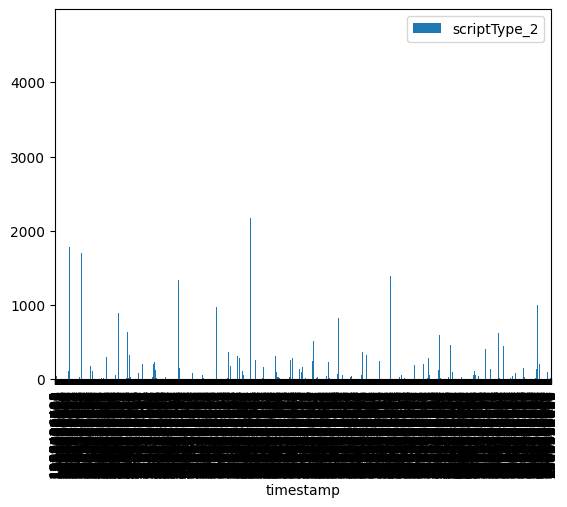

In [9]:
script_groups.sample(n=5000, random_state=42).plot.bar(x='timestamp', y='scriptType_2', rot=90)

# percentage

In [23]:
sc_pcg = script_groups

sc_pcg['total_count'] = sc_pcg[['scriptType_0', 'scriptType_1', 'scriptType_2', 'scriptType_3']].sum(axis=1)

# Calculate percentage of each script type
sc_pcg['scriptType_0_percent'] = (sc_pcg['scriptType_0'] / sc_pcg['total_count']) #* 100
sc_pcg['scriptType_1_percent'] = (sc_pcg['scriptType_1'] / sc_pcg['total_count']) #* 100
sc_pcg['scriptType_2_percent'] = (sc_pcg['scriptType_2'] / sc_pcg['total_count']) #* 100
sc_pcg['scriptType_3_percent'] = (sc_pcg['scriptType_3'] / sc_pcg['total_count']) #* 100

# Drop the total_count column (optional)
sc_pcg = sc_pcg.drop(columns=['total_count', 'scriptType_0', 'scriptType_1', 'scriptType_2', 'scriptType_3'])

print(sc_pcg.info())

#print(sc_pcg)

#sc_pcg.sample(n=5000, random_state=42).plot.bar(x='timestamp', y='scriptType_2_percent', rot=90)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214469 entries, 0 to 214468
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   timestamp             214469 non-null  uint32 
 1   scriptType_1_percent  214469 non-null  float64
 2   scriptType_0_percent  214469 non-null  float64
 3   scriptType_2_percent  214469 non-null  float64
 4   scriptType_3_percent  214469 non-null  float64
dtypes: float64(4), uint32(1)
memory usage: 7.4 MB
None
